In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# date of datas
date = "0913"

# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# dir
first_order_data_dir = './calibration/first_order_position_line_pattern/2023%s'%date

# center points for all patches
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])

### Bring band pass filter captured image

In [3]:
# first_order_data = []

# exp_indx = 1

# for i in range(318): 
#     first_order_dir = os.path.join(first_order_data_dir, '%snm_crop/calibration00/capture_%04d.png')

#     first_order_imgs = np.array([cv2.imread(first_order_dir%(wvls[w], i), -1)[:,:,::-1] for w in range(len(wvls))])
#     first_order_data.append(first_order_imgs)
    
# first_order_data = np.array(first_order_data) # 318, 25, 580, 890, 3

### Save or bring band pass filter captured image for each wvl, rgb

In [4]:
# np.save('./first_order_data.npy', first_order_data)
first_order_data = np.load('./npy/first_order_data.npy')

In [5]:
first_order_data.shape # illumination index, wvls, H, W, rgb

(318, 23, 580, 890, 3)

In [6]:
first_order_data_transposed = first_order_data.transpose(2,3,0,1,4)
print(first_order_data_transposed.shape) # H, W, illumination index, wvls, rgb

(580, 890, 318, 23, 3)


### Save data for each patches for each wavelengths

In [7]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, len(wvls)))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 3

# max value defined for each illumination pattern 

for w in range(len(wvls)):
    for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
            
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (first_order_data_transposed[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l, w] / (65535)).reshape(-1, 3).mean(axis = 0)
                max_idx = np.argmax(rgb_intensity) # rgb 채널 중 max 값 넣기

                patches_rgb_real[l, p, w] = rgb_intensity[max_idx] # illum index, patch, wvls

In [8]:
# np.save('patches_rgb_real.npy', patches_rgb_real)
patches_rgb_real = np.load('./npy/patches_rgb_real.npy')

In [9]:
patches_rgb_real.shape

(318, 24, 23)

In [10]:
# for i in range(23):
#     plt.figure()
#     plt.plot(patches_rgb_real[:,:,i])

### Find first order dispersed light peak illumination index

In [11]:
peak_illum_idx = np.zeros(shape=(n_patches, len(wvls)))

0, 6, 12, 18 번 patch는 zero index 가 대략 100 임 & +1 order 빛

1, 7, 13, 19 번 patch는 zero index 가 대략 140 임 & +1 order 빛

2, 8, 14, 20 번 patch는 zero index 가 대략 160 임 & -1 order 빛

3, 9, 15, 21 번 patch는 zero index 가 대략 200 임 & -1 order 빛

4, 10, 16, 22 번 patch는 zero index 가 대략 240 임 & -1 order 빛

5, 11, 17, 23 번 patch는 zero index 가 대략 270 임 & -1 order 빛

<참고>

12번의 blue patch는 마지막 660nm 인덱스는 261로 매뉴얼하게 넣음

2 번의 patch 는 마지막 660nm 빛이 아예 안찍힘

8 번의 patch 는 마지막 660nm 빛이 아예 안찍힘

23 번의 patch는 첫번째 430nm 인덱스는 166로 메뉴얼하게 넣음

In [12]:
# patches_rgb_real (318, 24, 23)

# zero_idx = 250

for p in range(24):
    for w in range(len(wvls)):
        
        if (p == 0) or (p == 6) or (p == 12) or (p == 18): # +1
            zero_idx = 120
            max_idx = np.argmax(patches_rgb_real[zero_idx:,p, w]) + zero_idx
            peak_illum_idx[p, w] = max_idx
        
        if (p == 1) or (p == 7) or (p == 13) or (p == 19): # +1
            zero_idx = 140
            max_idx = np.argmax(patches_rgb_real[zero_idx:,p, w]) + zero_idx
            peak_illum_idx[p, w] = max_idx
        
        if (p == 2) or (p == 8) or (p == 14) or (p == 20): # -1
            zero_idx = 150
            max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
            peak_illum_idx[p, w] = max_idx
            
        if (p == 3) or (p == 9) or (p == 15) or (p == 21): # -1
            zero_idx = 180
            max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
            peak_illum_idx[p, w] = max_idx
            
        if (p == 4) or (p == 10) or (p == 16) or (p == 22): # -1
            zero_idx = 220
            max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
            peak_illum_idx[p, w] = max_idx
            
        if (p == 5) or (p == 11) or (p == 17) or (p == 23): # -1
            zero_idx = 250
            max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
            peak_illum_idx[p, w] = max_idx
        
    # for w in range(len(wvls)):
    #     plt.figure()
    #     plt.ylim([0, 1])
    #     plt.plot(patches_rgb_real[:,p, w]), plt.title('%02d patch %dnm'%(p, wvls[w]))
        
        # # for +1 orders
        # max_idx = np.argmax(patches_rgb_real[zero_idx:,p, w]) + zero_idx
        # peak_illum_idx[p, w] = max_idx
        
        # # for -1 orders
        # max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
        # peak_illum_idx[p, w] = max_idx

In [13]:
# 18 : 203 - 260 // zero 101
# 17 : 163 - 110 // zero 268
# 12 : 204 - 258 // zero 99
# 13 : 239 - 297 // zero 134
# 14 : 63 - 4 // zero 168

In [14]:
max_idx = np.argmax(patches_rgb_real[:150,2])

In [15]:
max_idx

1222

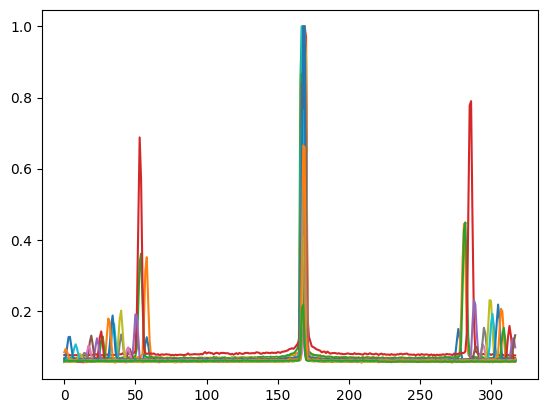

In [16]:
plt.plot(patches_rgb_real[:,2])

[430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600
 610 620 640 650 660]
[ 58.  58.  54.  53.  50.  46.  45.  40.  40.  35.  34.  31.  27.  26.
  23.  19.  17.  14.  11.   8.   4.   1. 113.]


([<matplotlib.lines.Line2D at 0x29483a38cc8>], Text(0.5, 1.0, '02 patch'))

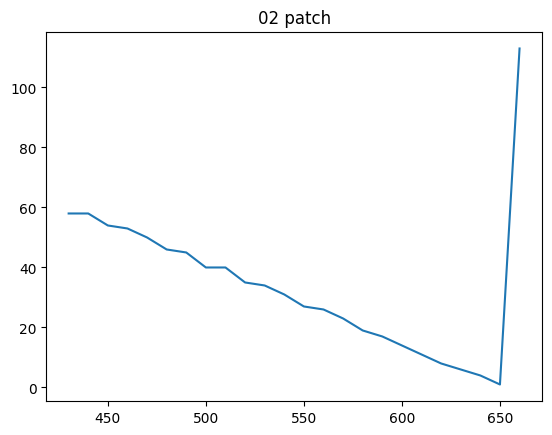

In [17]:
patch_num = 2
print(wvls)
print(peak_illum_idx[patch_num])
plt.plot(wvls, peak_illum_idx[patch_num]), plt.title('%02d patch'%patch_num)

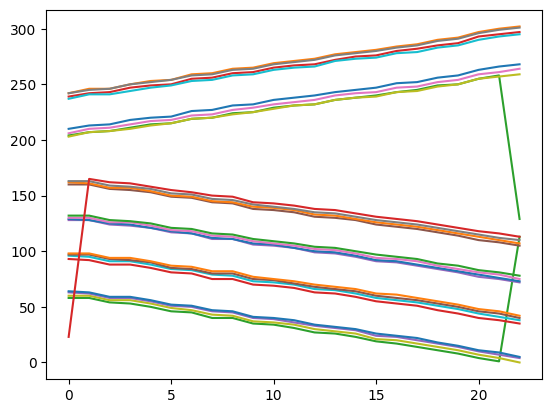

In [18]:
for i in range(len(peak_illum_idx)):
    plt.plot(peak_illum_idx[i])

In [19]:
np.save('./peak_illum_idx.npy', peak_illum_idx)

### Bring first order illumination index

In [20]:
peak_illum_idx = np.load('./npy/peak_illum_idx.npy')

### Find zero order index

In [21]:
zero_illum_idx = np.zeros(shape=(n_patches, len(wvls)))

In [ ]:
# patches_rgb_real (318, 24, 23)

for p in range(24):
    for w in range(len(wvls)):
        plt.figure()
        plt.ylim([0, 1])
        plt.plot(patches_rgb_real[:,p, w]), plt.title('%02d patch %dnm'%(p, wvls[w]))
    
        max_idx = np.argmax(patches_rgb_real[:,p,w])
        zero_illum_idx[p, w] = max_idx

In [23]:
zero_illum_idx.shape

(24, 23)

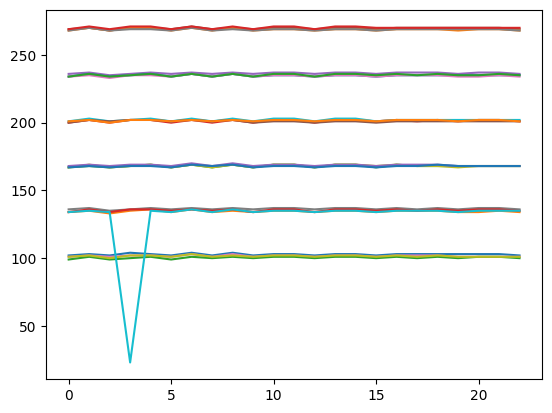

In [24]:
for p in range(n_patches):
    plt.plot(zero_illum_idx[p])
    
# 19 번 패치의 3번째 wvl : 23 index가 zero order라고 뜸 (outlier) > 메뉴얼하게 변경
zero_illum_idx[19,3] = zero_illum_idx[19,4] 

In [25]:
np.save('zero_illum_idx.npy', zero_illum_idx)

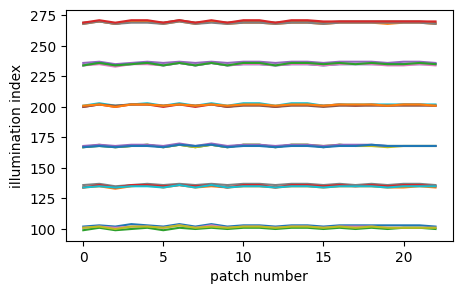

In [26]:
plt.figure(figsize=(5,3))
for p in range(n_patches):
    plt.plot(zero_illum_idx[p]) # zero order index
    plt.xlabel('patch number')
    plt.ylabel('illumination index')

In [27]:
peak_illum_idx[2]

array([58., 58., 54., 53., 50., 46., 45., 40., 40., 35., 34., 31., 27.,
       26., 23., 19., 17., 14., 11.,  8.,  4.,  1.,  0.])

In [28]:
# np.save('./zero_illum_idx.npy', zero_illum_idx)

In [29]:
diff = zero_illum_idx - peak_illum_idx

Text(0, 0.5, 'difference 0-order first order 430nm index')

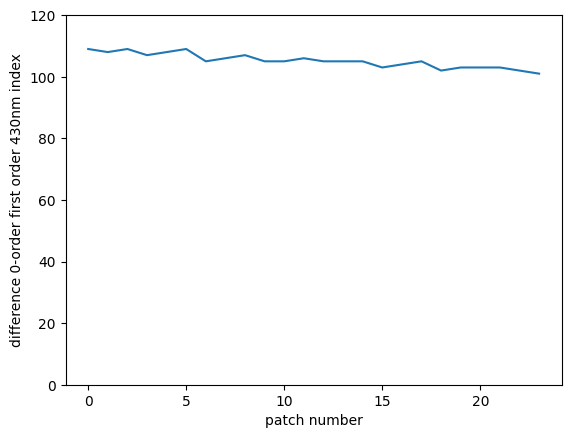

In [30]:
x = np.arange(0, n_patches)
plt.ylim([0, 120])
plt.plot(x, abs(diff[:,0]))
plt.xlabel('patch number')
plt.ylabel('difference 0-order first order 430nm index')


Text(0, 0.5, 'difference first order 430nm and 660nm index')

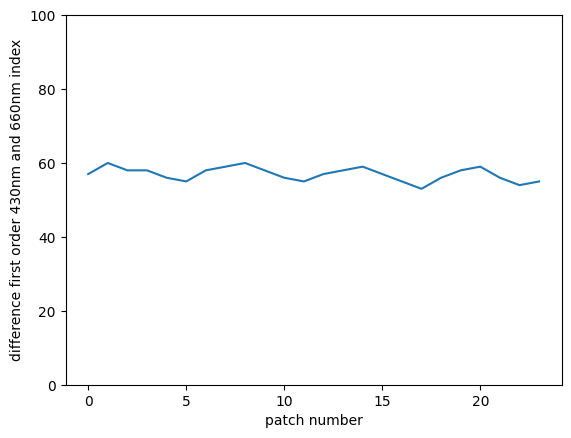

In [31]:
x = np.arange(0, n_patches)
plt.ylim([0, 100])
plt.plot(x, abs(peak_illum_idx[:,0] - peak_illum_idx[:,-1]))
plt.xlabel('patch number')
plt.ylabel('difference first order 430nm and 660nm index')

In [32]:
abs(peak_illum_idx[:,0] - peak_illum_idx[:,-1])[12:18]

array([57., 58., 59., 57., 55., 53.])

In [33]:
# abs(peak_illum_idx[:,0] - peak_illum_idx[:,-1]).mean()

In [34]:
peak_illum_idx[2]

array([58., 58., 54., 53., 50., 46., 45., 40., 40., 35., 34., 31., 27.,
       26., 23., 19., 17., 14., 11.,  8.,  4.,  1.,  0.])

In [35]:
zero_illum_idx[2]

array([167., 168., 167., 168., 169., 167., 169., 167., 169., 167., 169.,
       169., 167., 169., 169., 167., 169., 168., 168., 168., 168., 168.,
       168.])

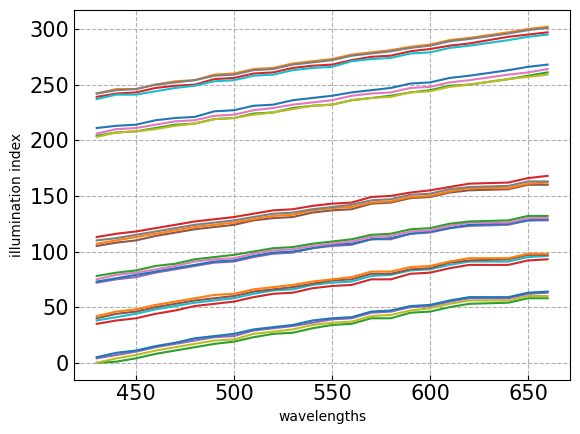

In [37]:
wvls 
pfirst_patch = [0, 6, 12, 18, 1, 7, 13, 19]

fig, ax = plt.subplots()

for p in range(n_patches):
    if p not in pfirst_patch:
        plt.plot(wvls, peak_illum_idx[p,::-1])
        inv_peak_illum_idx = peak_illum_idx[p,::-1]
        a = abs(inv_peak_illum_idx[0] - inv_peak_illum_idx[-1])
        # print("%02d patch slope %d"%(p, a))
        # continue
    else:
        plt.plot(wvls, peak_illum_idx[p])
        a = abs(peak_illum_idx[p,0] - peak_illum_idx[p,-1])
        # print("%02d patch slope %d"%(p, a))
        # continue
    ax.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
    plt.xlabel('wavelengths')
    plt.grid(linestyle = '--')
    plt.ylabel('illumination index')
    plt.savefig('./peak_illum.svg')